<a href="https://colab.research.google.com/github/yohanesnuwara/reservoir-engineering/blob/master/Unit%209%20Dry-Gas%20Reservoirs/notebook/9_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Unit 9 Dry-Gas Reservoirs**

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
!git clone https://www.github.com/yohanesnuwara/reservoir-engineering

Cloning into 'reservoir-engineering'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 971 (delta 32), reused 0 (delta 0), pack-reused 909
Receiving objects: 100% (971/971), 12.25 MiB | 34.84 MiB/s, done.
Resolving deltas: 100% (427/427), done.


## **Functions (Chapter 9.2 Volumetrics and Recovery Factors)**

In [0]:
def recovery_factor_drygas_waterdrive(swi, Bgi, sgr, Bga):
  "recovery factor of dry gas reservoir with waterdrive"
  # gas FVF at abandonment pressure (RB/scf)
  # sgr: residual gas saturation
  rf = (((1 - swi) / Bgi) - (sgr / Bga)) / ((1 - swi) / Bgi)
  return(rf)

def recovery_factor_drygas_volumetric(Bgi, Bga):
  "recovery factor of dry gas reservoir with NO waterdrive"  
  # gas FVF at abandonment pressure (RB/scf)
  # sgr: residual gas saturation
  rf = 1 - (Bgi / Bga)
  return(rf)

## **Chapter 9.3 Gas Equivalence to Condensates and Water**

It's already mentioned in book that **1 STB of condensate is equivalent with 700 to 750 scf of gas** measured at standard conditions (`T = 519.67 R; 15.6 C; 60 F` and `P = 14.7 psi; 101.325 kPa`). I'm interested to find out the **API gravity** of condensates, by re-arranging Equation 9.5, 9.6, and 9.7)

In [4]:
"Gas equivalence to condensate"

Tsc = 519.57 # standard temp in Rankine
psc = 14.7 # standard pressure in psi
R = 10.732
rho_w = 350.16 # water density in lbm/STB
V1 = 700 # the smallest value of gas equivalence (scf)
V2 = 750 # the largest value of gas equivalence (scf)

# solve for api from Equation 9.5, 9.6, 9.7
from scipy.optimize import fsolve

def f(api):
  so = 141.5 / (api + 131.5) # so: specific gravity of oil (dimensionless)
  Mo = 5854 / (api - 8.811) # molecular weight of oil
  n = (rho_w * so) / Mo
  # real gas equation: V = nRT/p
  f1 = ((n * R * Tsc) / psc) - V1
  return(f1)

api1 = fsolve(f, 40)
api1 = np.float64(api1)

def f(api):
  so = 141.5 / (api + 131.5) # so: specific gravity of oil (dimensionless)
  Mo = 5854 / (api - 8.811) # molecular weight of oil
  n = (rho_w * so) / Mo
  # real gas equation: V = nRT/p
  f2 = ((n * R * Tsc) / psc) - V2
  return(f2)

api2 = fsolve(f, 40)
api2 = np.float64(api2)

print("API gravity of condensate is between:", api1, "API and:", api2, "API")

API gravity of condensate is between: 47.93319100231802 API and: 51.57941144067795 API


In most references, the value of API for condesates is greater than this value range (50 to 80 API). For example:

<div>
<img src="https://user-images.githubusercontent.com/51282928/75760535-0335de80-5d6a-11ea-899d-a1f7fde50c80.jpg" width="500"/>
</div>

**100 STB of condensate with API gravity of 65**, is therefore equivalent to: 

In [5]:
def condensate_to_gas_equivalence(api, stb):
  "Derivation from real gas equation"
  Tsc = 519.57 # standard temp in Rankine
  psc = 14.7 # standard pressure in psi
  R = 10.732
  rho_w = 350.16 # water density in lbm/STB

  so = 141.5 / (api + 131.5) # so: specific gravity of oil (dimensionless)
  Mo = 5854 / (api - 8.811) # molecular weight of oil
  n = (rho_w * so) / Mo  

  V1stb = ((n * R * Tsc) / psc)
  V = V1stb * stb
  return(V1stb, V)

stb = 100; api = 65

V1stb, V = condensate_to_gas_equivalence(api, stb)
print("1 STB of condensate is equivalent to:", V1stb, "scf of gas.", stb, "STB of condensate is equivalent to:", V, "scf of gas")

1 STB of condensate is equivalent to: 918.0501371833875 scf of gas. 100 STB of condensate is equivalent to: 91805.01371833876 scf of gas


The gas equivalence is also simplified into a more general form (Eq 9.5)

$$V = 132849\frac{\gamma}{M}$$

$M$ is molecular weight 
* for condensate/oil, $M_o = \frac{42.43\gamma_o}{1.008-\gamma_o}$ with $\gamma_o$ is oil specific gravity; $\gamma_o = \frac{141.5}{api + 131.5}$ and $api$ is the API gravity
* for water, $M_w = 18$ and $\gamma_w = 1$

**100 STB of water**, is therefore equivalent to: 

In [6]:
stb = 100
V1stb = 132849 * (1 / 18)
V = stb * V1stb
print(stb, "STB of water is equivalent to:", V, "scf of gas")

100 STB of water is equivalent to: 738050.0 scf of gas


## **Chapter 9.4 Material-Balance Analysis of Dry-Gas Reservoirs**

General equation of material balance in dry gas reservoirs:
$$F = Gfgi \cdot Eg + \Delta W + Gfgi \cdot Bgi \cdot Efw$$

$Gfgi \cdot Bgi \cdot Efw = 0$ because gas normally has compressibility higher than water and rock. In **no waterdrive**, aquifer influx $\Delta W = 0$. The material balance becomes:

In [0]:
def matbalance_drygas_volumetric(Gp, Bg, Bgi, Gfgi):
  # no waterdrive
  right_term = Gp * Bg
  left_term = Gfgi * (Bg - Bgi)
  return(right_term, left_term) # right term = left term (balance)

$B_g = \frac{zTp_s}{pT_s}$ from Chapter 2 is subtituted into the material balance, it becomes Eq 9.15: 

$$\frac{p}{z} = \frac{pi}{zi} - \frac{pi \cdot Gp}{zi \cdot Gfgi}$$ 

Re-arranging the equation gives **estimation of OGIP**:

In [0]:
def ogip_matbalance_drygas_volumetric(Gp, p, z, pi, zi):
  # no waterdrive
  Gfgi = Gp / (1 - ((p * zi) / (pi * z)))
  return(Gfgi)

### Example 9.1 Determination of OGIP by Material-Balance

Re-arranging Eq 9.15:

$$\frac{p}{z} = \frac{pi}{zi} - \frac{pi \cdot G_p}{zi \cdot G_{fgi}}$$ 

$$\frac{G_p}{G_{fgi}}=\frac{p_i-p}{z_i-z} \frac{z_i}{p_i}$$

$$G_{fgi}=\frac{G_p}{(\frac{p_i-p}{z_i-z}) (\frac{z_i}{p_i})}$$

$$G_{fgi}=\frac{G_p}{\frac{p_iz_i-pz_i}{p_iz_i-p_iz}}$$

Resulting:

$$G_{fgi}=\frac{G_p}{1-\frac{pz_i}{p_iz}}$$

In [9]:
"Task. determine OGIP"

# known: volumetric (no waterdrive) dry gas reservoir
pi = 3000 # initial pressure, psi
temp = 190 # formation temperature, F
p_current = 2876 # current pressure after production, psia
Gp = 384 # gas production, MMscf
pc = 671 # critical pressure, psia
Tc = 358 # critical temperature, Rankine

# conversion
Gp = Gp * 1E+06 # from MMscf to scf

# determine gas compressibility factor z using Dranchuk-Abou Kassem EOS rather than using chart
import os, sys
sys.path.append('/content/reservoir-engineering/Unit 2 Review of Rock and Fluid Properties/functions')
from dranchuk_aboukassem import dranchuk

# convert temperature from F to Rankine
temp_conv = temp + 459.67

P_pr_initial = pi / pc
P_pr_current = p_current / pc
T_pr = temp_conv / Tc

rho_pr_initial, z_initial = dranchuk(T_pr, P_pr_initial)
rho_pr_current, z_current = dranchuk(T_pr, P_pr_current)
print("Initial gas compressibility factor:", z_initial) 
print("Current gas compressibility factor:", z_current) 

# calculate OGIP
Gfgi = ogip_matbalance_drygas_volumetric(Gp, p_current, z_current, pi, z_initial)
print("Original Gas in Place:", Gfgi / 1E+09, "Bscf")

Initial gas compressibility factor: 0.9069024150713222
Current gas compressibility factor: 0.9039322509456235
Original Gas in Place: 10.056746912653262 Bscf


Using z-factor chart (book)

In [10]:
z_initial = 0.912
z_current = 0.907
print("Initial gas compressibility factor:", z_initial) 
print("Current gas compressibility factor:", z_current) 

# calculate OGIP
Gfgi = ogip_matbalance_drygas_volumetric(Gp, p_current, z_current, pi, z_initial)
print("Original Gas in Place:", Gfgi / 1E+09, "Bscf")

Initial gas compressibility factor: 0.912
Current gas compressibility factor: 0.907
Original Gas in Place: 10.652312209444611 Bscf


## **Chapter 9.5 Material-Balance Plots to Determine OGIP**

### Plot 9.1: $G_p B_g$ vs $B_g - B_gi$
* **Straight line** indicates gas is volumetric (waterdrive is negligible). Intercept $b = 0$ and slope $m = Gfgi$
* **Curving upward** indicates waterdrive is present ($\Delta W$ is not negligible, See Chapter 9.6)
* **Curving downward** indicates that $Efg$ is not negligible and formation compressibility $ct$ is comparable with gas compressibility (See Chapter 9.7).

### Plot 9.2: $\frac{p}{z}$ vs $G_p$
* **Straight line** indicates gas is volumetric (waterdrive is negligible). Intercept $b = Gfgi$ and slope $m = \frac{p_i}{z_i \cdot Gfgi}$
* **Curving upward** indicates waterdrive is present ($\Delta W$ is not negligible, See Chapter 9.6)
* **Curving downward** indicates that $Efg$ is not negligible and formation compressibility $ct$ is comparable with gas compressibility (See Chapter 9.7).

### Example 9.2 Determination of OGIP by Material-Balance Plot

OGIP calculated using Plot 9.1: 10.748033224262944 Bscf
OGIP calculated using Plot 9.2: 10.758397571436433 Bscf


(0.0, 3369.869895288443)

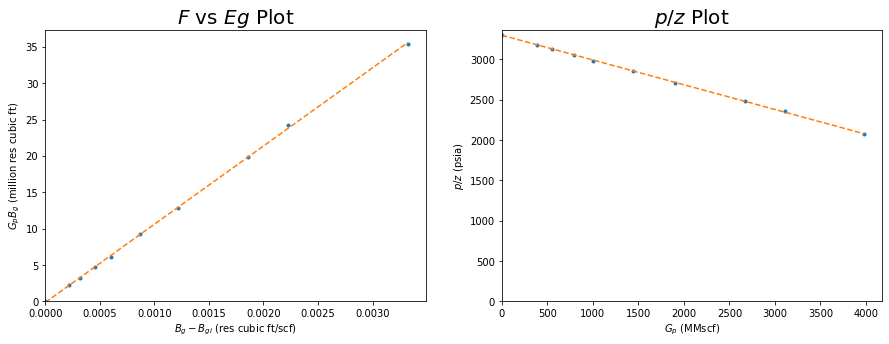

In [11]:
"Task. determine OGIP"

# known Table 9.1 
pressure = np.array([3000, 2876, 2824, 2755, 2688, 2570, 2435, 2226, 2122, 1866])
Gp = np.array([0, 384, 550, 788, 1002, 1445, 1899, 2670, 3113, 3982])

# properties similar to Example 9.1
temp = 190 + 459.67 # F to Rankine
Tc = 358
pc = 671

# calculate gas z factor and FVF
z_arr = []
Bg_arr = []
for i in range(len(pressure)):
  P_pr = pressure[i] / pc
  T_pr = temp / Tc
  rho_pr, z = dranchuk(T_pr, P_pr)
  Bg = 0.0282793 * z * temp / pressure[i] # Eq 2.2, temp in Rankine, p in psia
  z_arr.append(float(z))
  Bg_arr.append(float(Bg))

"Using Plot 9.1"
Eg = np.array(Bg_arr) - Bg_arr[0]
Gp_Bg = Gp * np.array(Bg_arr)

# regression
sys.path.append('/content/reservoir-engineering/Unit 7 Introduction to Well-Test Analysis/functions')
from regression import regression
c1, m1 = regression(Eg, Gp_Bg)

# straight line has slope m
Gfgi_plot1 = np.abs(m1)
print("OGIP calculated using Plot 9.1:", Gfgi_plot1 / 1E+03, "Bscf")

"Using Plot 9.2"
p_z = pressure / z_arr

# regression
sys.path.append('/content/reservoir-engineering/Unit 7 Introduction to Well-Test Analysis/functions')
from regression import regression
c2, m2 = regression(Gp, p_z)

# straight line has equation of: y=mx+c. Gfgi is the line intercept when y=0
Gfgi_plot2 = c2 / np.abs(m2)
print("OGIP calculated using Plot 9.2:", Gfgi_plot2 / 1E+03, "Bscf")

# Material-Balance Plots
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(Eg, Gp_Bg, '.')
# plot regression
F_reg = m1 * Eg + c1
plt.plot(Eg, F_reg, '--')
plt.title('$F$ vs $Eg$ Plot', size=20)
plt.ylabel('$G_p B_g$ (million res cubic ft)'); plt.xlabel('$B_g-B_{gi}$ (res cubic ft/scf)')
plt.xlim(xmin=0); plt.ylim(ymin=0)

plt.subplot(1, 2, 2)
plt.plot(Gp, p_z, '.')
# plot regression
p_z_reg = m2 * Gp + c2
plt.plot(Gp, p_z_reg, '--')
plt.title('$p/z$ Plot', size=20)
plt.xlabel('$G_p$ (MMscf)'); plt.ylabel('$p/z$ (psia)')
plt.xlim(xmin=0); plt.ylim(ymin=0)

## **Chapter 9.6 Waterdrive Gas Reservoirs**

### **Plot 9.3**: $\frac{F}{E_g + Bgi \cdot Efw}$ vs. $G_p$ or $t$ (Waterdrive Diagnostic Plot)

* If the line is **horizontal**, indicates **volumetric gas reservoir** (no waterdrive), equal to $Gfgi$.
* If the line is **sloping**, the gas reservoir has **waterdrive**

### **Plot 9.4**: $\frac{F}{E_g}$ vs. $\sum (\Delta p \cdot We_d)$ (Havlena and Odeh)

$We_d$ is calculated using **aquifer infux** in Unit 8. The slope is constant, equals to **aquifer constant, $k'$**. Intercept equals to $Gfgi$

### **Plot 9.5**: $F$ vs. $E_c$ (Sills)

Where $E_c = E_g + Bgi \cdot Efw + \frac{2(c_f + c_w)Bgi \sum (\Delta p \cdot We_d)}{1-Sw_i} \cdot (\frac{aquiferthickness}{reservoirthickness})$

$m = Gfgi$ and $intercept = 0$

### Example 9.3 Verification of Volumetric Nature of a Gas Reservoir

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


Slope: 0.18826023842710268 is relatively horizontal
Intercept is OGIP: 10.130185127404664 Bscf


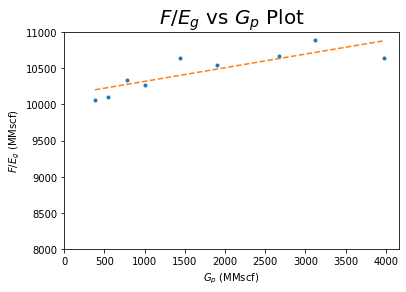

In [12]:
"Task. use Plot 9.3 to verify that reservoir in Example 9.2 is volumetric (no waterdrive)"

axisx = (np.array(Gp))[1:]
F = Gp_Bg
axisy = (np.array(F / Eg))[1:]

# regression
sys.path.append('/content/reservoir-engineering/Unit 7 Introduction to Well-Test Analysis/functions')
from regression import regression
c3, m3 = regression(axisx, axisy)
y_reg = m3 * axisx + c3

# waterdrive diagnostic plot
plt.plot(axisx, axisy, '.')
plt.plot(axisx, y_reg, '--')
plt.title('$F/E_g$ vs $G_p$ Plot', size=20)
plt.xlabel('$G_p$ (MMscf)'); plt.ylabel('$F/E_g$ (MMscf)')
plt.xlim(xmin=0); plt.ylim(8000, 11000)

print("Slope:", m3, "is relatively horizontal")
print("Intercept is OGIP:", c3 / 1E+03, "Bscf")

Therefore, the reservoir is most likely to be **volumetric (NO waterdrive)**

### Example 9.4 Analysis of a Waterdrive Gas Reservoir

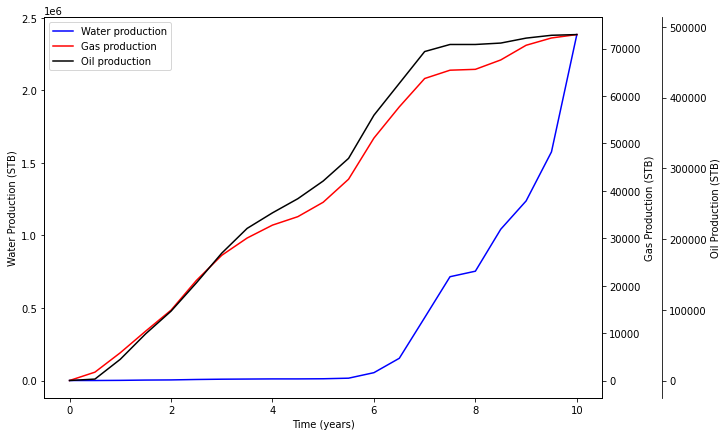

In [13]:
# load data
dataprod = pd.read_csv('/content/reservoir-engineering/Unit 9 Dry-Gas Reservoirs/data/Table 9.4-Reservoir Data and Documented Pressures and Production Example 9.4.csv')

# visualize data Gp, Np, Wp in one plot
time = np.array(dataprod.t); Gp = np.array(dataprod.Gp); Np = np.array(dataprod.Np); Wp = np.array(dataprod.Wp)

fig = plt.figure(figsize=(10,7))
host = fig.add_subplot(111)

par1 = host.twinx()
par2 = host.twinx()

host.set_xlabel("Time (years)")
host.set_ylabel("Water Production (STB)")
par1.set_ylabel("Gas Production (STB)")
par2.set_ylabel("Oil Production (STB)")

# color1 = plt.cm.viridis(0)
# color2 = plt.cm.viridis(0.5)
# color3 = plt.cm.viridis(.9)

p1, = host.plot(time, Wp, color='blue',label="Water production")
p2, = par1.plot(time, Gp, color='red', label="Gas production")
p3, = par2.plot(time, Np, color='black', label="Oil production")

lns = [p1, p2, p3]
host.legend(handles=lns, loc='best')

# right, left, top, bottom
par2.spines['right'].set_position(('outward', 60))      

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


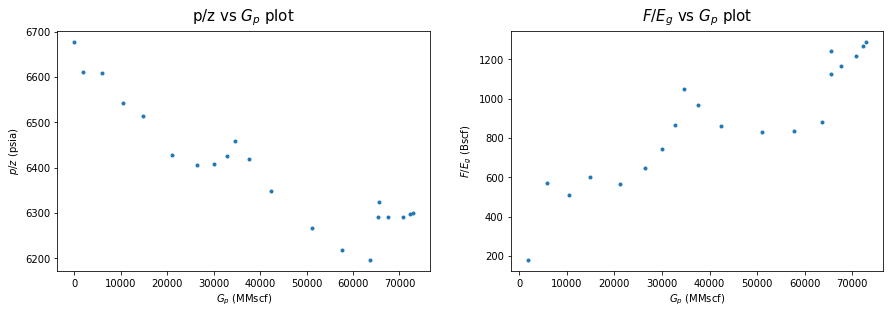

In [14]:
pressure = np.array(dataprod.p); z = np.array(dataprod.z)
p_z = pressure / z

# conversion
Gp = np.array(dataprod.Gp) * 1E+06 # mmscf to scf
Bg = np.array(dataprod.Bg) * (1 / (1E+03)) # res ft3/mscf to resft3/scf
F = Gp * Bg # result in res ft3
Eg = Bg - Bg[0] # resft3/scf
F_Eg = F / Eg # res ft3 * (scf/res ft3), result in scf
F_Eg = F_Eg / (1E+09) # convert scf to Bscf

plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
plt.plot((Gp / 1E+06), p_z, '.') # plot x in mmscf
plt.title('p/z vs $G_p$ plot', size=15, pad=10)
plt.xlabel('$G_p$ (MMscf)'); plt.ylabel('$p/z$ (psia)')

plt.subplot(1,2,2)
plt.plot((Gp / 1E+06), F_Eg, '.')
plt.title('$F/E_g$ vs $G_p$ plot', size=15, pad=10)
plt.xlabel('$G_p$ (MMscf)'); plt.ylabel('$F/E_g$ (Bscf)')

plt.tight_layout(pad=3.0) # set distance between two plots

Original Gas in Place from p/z plot: 1.3384478020004833 Tscf


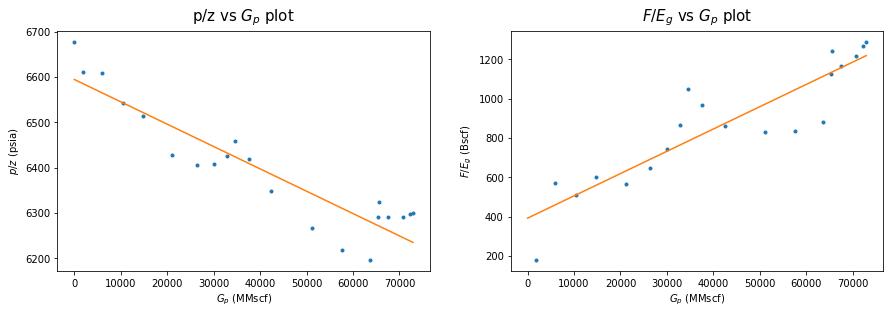

In [15]:
# regression to estimate OGIP
c4, m4 = regression(Gp, p_z)
Gfgi_pz = c4 / np.abs(m4)
print("Original Gas in Place from p/z plot:", Gfgi_pz / 1E+12, "Tscf") # convert scf to Tscf

# the first row contains NaN, so filter it out
Gp_new = Gp[1:]; F_Eg_new = F_Eg[1:]
c5, m5 = regression(Gp_new, F_Eg_new)

y_reg4 = c4 + m4 * Gp
y_reg5 = c5 + m5 * Gp

plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
plt.plot((Gp / 1E+06), p_z, '.')
plt.plot((Gp / 1E+06), y_reg4)
plt.title('p/z vs $G_p$ plot', size=15, pad=10)
plt.xlabel('$G_p$ (MMscf)'); plt.ylabel('$p/z$ (psia)')

plt.subplot(1,2,2)
plt.plot((Gp / 1E+06), F_Eg, '.')
plt.plot((Gp / 1E+06), y_reg5)
plt.title('$F/E_g$ vs $G_p$ plot', size=15, pad=10)
plt.xlabel('$G_p$ (MMscf)'); plt.ylabel('$F/E_g$ (Bscf)')

plt.tight_layout(pad=3.0) # set distance between two plots

From p/z plot, the OGIP estimated is 1.33 Tscf. However, the **waterdrive diagnostic plot** of $F/E_g$ vs $G_p$ indicates a sloping upward, meaning there's waterdrive in the reservoir, therefore the OGIP estimated from p/z plot is **misleading**. OGIP calculated by Sills is 231 Bscf.

After knowing that the reservoir has waterdrive, calculate the aquifer influx ($W_e$) (Eq 9.18)

Check units first:
$$W_e=B_wW_p+F-G_{fgi}E_g-G_{fgi}B_{gi}E_{fw}$$
$$W_e=(\frac{RB}{STB} STB) + (res ft^3) - (Bscf \cdot \frac{res ft^3}{scf}) - (Bscf \cdot \frac{res ft^3}{scf} \cdot)$$

$G_{fgi}$ should be converted to $scf$


In [0]:
Gfgi = 231 * 1E+09 # 231 from Sills, bscf to scf

In Table 9.5, $F$ is in unit million res bbl. It's wrong, **should be million res $ft^3$** instead of million  res bbl. 

In [0]:
F_conv = F / 1E+06 # from ft3 to million ft3

If we stick to the book, we will use this number instead. 

In [18]:
# known
cf = 3.5E-6 # psi^-1
cw = 2.9E-6 # psi^-1
swi = 0.21

Bw = np.array(dataprod.Bw)
pi = pressure[0]
Efw = ((cf + cw * swi) / (1 - swi)) * (pi - pressure)

Bgi = Bg[0]
Bw_Wp = Bw * Wp
Gfgi_Eg = Gfgi * Eg
Gfgi_Bgi_Efw = Gfgi * Bgi * Efw
We = (Bw * Wp) + F - (Gfgi * Eg) - (Gfgi * Bgi * Efw)
We

array([       0.        ,  -391769.43931137,  1794213.15521873,
        2947743.77539444,  4824099.06667848,  6620390.00001773,
        9156722.88873721, 11253030.33472   , 13132682.96753925,
       14729619.10873369, 15715811.09711241, 17180391.69027949,
       20684302.19404558, 23730577.39849316, 27115561.71969114,
       30020925.41883038, 30726167.7060076 , 31604852.51883038,
       33585854.21883038, 34928897.41626581, 36243003.10823141])

In [19]:
result = pd.DataFrame({"Years": time, "Pressure": pressure, "F(million bbl)": F_conv, "Eg(RB/Mscf)": Eg * 1E+03, "F/Eg(Bscf)": F_Eg, "z": z, "We(res bbl)": We, "p/z(psia)": p_z})
print("Table 9.5-Calculated Parameters for Example 9.4")
result

Table 9.5-Calculated Parameters for Example 9.4


,Years,Pressure,F(million bbl),Eg(RB/Mscf),F/Eg(Bscf),z,We(res bbl),p/z(psia)
0,0.0,8490.0,0.000000,0.0000,NaN,1.271392,0.000000e+00,6677.720168
1,0.5,8330.0,0.959516,0.0054,177.688222,1.259897,-3.917694e+05,6611.651587
2,1.0,8323.0,3.195192,0.0056,570.570000,1.259299,1.794213e+06,6609.232597
3,1.5,8166.0,5.742156,0.0112,512.692500,1.248217,2.947744e+06,6542.131697
4,2.0,8100.0,8.214712,0.0136,604.022941,1.243516,4.824099e+06,6513.788323
5,2.5,7905.0,11.843856,0.0210,563.993133,1.229789,6.620390e+06,6427.931946
6,3.0,7854.0,14.873197,0.0230,646.660722,1.226208,9.156723e+06,6405.112346
7,3.5,7858.0,16.919654,0.0228,742.090105,1.226397,1.125303e+07,6407.386841
8,4.0,7900.0,18.401386,0.0212,867.989887,1.229449,1.313268e+07,6425.642707
9,4.5,7971.0,19.305422,0.0184,1049.207739,1.234314,1.472962e+07,6457.838119


Text(0.5, 1.0, 'Aquifer Influx over Production Years')

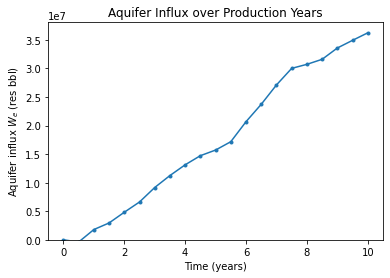

In [20]:
# visualize We
plt.plot(time, We, '.-')
plt.ylim(ymin=0)
plt.xlabel("Time (years)"); plt.ylabel("Aquifer influx $W_e$ (res bbl)")
plt.title("Aquifer Influx over Production Years")

## **Chapter 9.7 Overpressured Gas Reservoir**

### Example 9.5 Analysis of an Overpressured Gas Reservoir

In [80]:
# Task. Calculate OGIP using Plot 9.6 and 9.7

# knowns
temp = 266 # fahrenheit
swi = 0.35 # initial water saturation
cf = 15E-06 # psi^-1
cw = 3E-06 # psi^-1

columns = ['date', 'p', 'z', 'Gp', 'Np']
data = pd.read_csv('/content/reservoir-engineering/Unit 9 Dry-Gas Reservoirs/data/Table 9.6-Reservoir and Production for Example 9.5.csv', names=columns)

" calculate equivalence of condensate to gas, use 1 stb = 700 scf "
factor = 750
Gp_equi = ((data['Np'].values * 1E+6) * 700) / 1E+9

# preproc
Gp = data['Gp'].values 
Gp = Gp.astype(np.float) # convert from string (???) to float

"calculate total gas production"
Gp_total = Gp_equi + Gp

"Input gas FVF"
# no information about Tc and pc that can be used to calculate Bg

Bg = np.array([3111, 3134, 3176, 3212, 3244, 3288, 3347, 3378, 3449, 3505, 3542, 3734, 4210, 4438, 4880, 5402]) * 1E-06

"Compute Eg"

Eg = []
for i in range(len(Bg)-1):
  Bg_dif = Bg[i+1]-Bg[0]
  Eg.append(float(Bg_dif))
Eg = np.append(0, Eg)

"Compute p/z"
pz = data['p'].values / data['z'].values

"Compute F"
F = Gp_total * Bg

"Compute parameters for Plot 9.6 and 9.7"

# Eg+Bgi*Efw
Efw = ((cf + cw * swi) / (1 - swi)) * ((data['p'].values)[0] - (data['p'].values))
Eg_Bgi_Efw = Eg + Bg[0] * Efw

# F/(Eg+Bgi*Efw)
F_Eg_Bgi_Efw = F / Eg_Bgi_Efw

# (p/z)*(1-Efw)
p_z_Efw = pz * (1 - Efw)

# create dataframe for Table 9.7
table97 = pd.DataFrame({'Total Gp': Gp_total, 'Eg': Eg, 'p/z': pz, 'F': F, 
                        '(Eg+Bgi*Efw)': Eg_Bgi_Efw, 
                        'F/(Eg+Bgi*Efw)': F_Eg_Bgi_Efw,
                        '(p/z)*(1-Efw)': p_z_Efw})
table97

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide


,Total Gp,Eg,p/z,F,(Eg+Bgi*Efw),F/(Eg+Bgi*Efw),(p/z)*(1-Efw)
0,0.00,0.000000,6602.083333,0.000000,0.000000,NaN,6602.083333
1,413.43,0.000023,6552.891396,1.295690,0.000040,32789.136285,6518.103104
2,1728.23,0.000065,6467.195386,5.488858,0.000106,51659.289234,6381.441867
3,3394.43,0.000101,6395.089286,10.902909,0.000171,63738.156383,6251.075810
4,4482.27,0.000133,6331.306991,14.540484,0.000223,65127.773191,6147.613859
5,5788.33,0.000177,6247.269891,19.032029,0.000292,65161.887087,6016.189144
6,7930.94,0.000236,6136.400323,26.544856,0.000382,69441.700605,5847.902654
7,9204.76,0.000267,6080.459770,31.093679,0.000428,72581.944694,5765.014404
8,11052.92,0.000338,5954.081633,38.121521,0.000530,71869.291004,5585.796493
9,12363.91,0.000394,5859.633827,43.335505,0.000608,71273.823968,5456.533390


#### Plot 9.1 and 9.2 to confirm the existence of overpressure

Both plots confirm the existence of overpressure

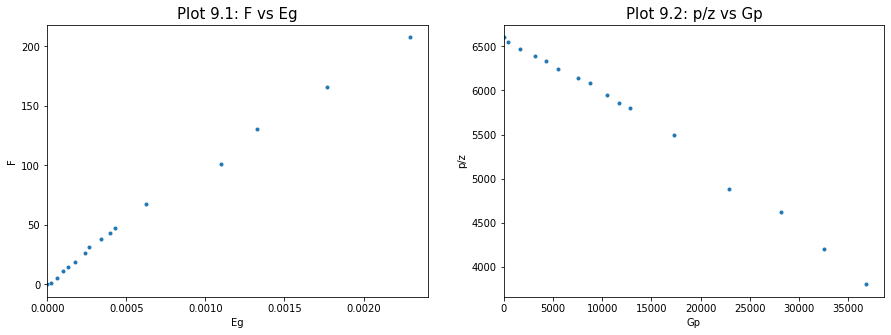

In [94]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(Eg, F, '.')
plt.title('Plot 9.1: F vs Eg', size=15)
plt.xlim(xmin=0)
plt.xlabel('Eg'); plt.ylabel('F')

plt.subplot(1,2,2)
plt.plot(data['Gp'].values, pz, '.')
plt.title('Plot 9.2: p/z vs Gp', size=15)
plt.xlim(xmin=0)
plt.xlabel('Gp'); plt.ylabel('p/z')

plt.show()

#### Plot 9.6 and 9.7 to calculate OGIP

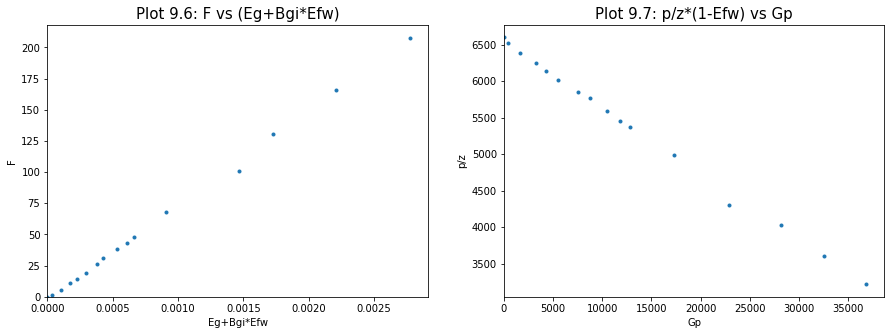

In [96]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(Eg_Bgi_Efw, F, '.')
plt.title('Plot 9.6: F vs (Eg+Bgi*Efw)', size=15)
plt.xlim(xmin=0); plt.ylim(ymin=0)
plt.xlabel('Eg+Bgi*Efw'); plt.ylabel('F')

plt.subplot(1,2,2)
plt.plot(data['Gp'].values, p_z_Efw, '.')
plt.title('Plot 9.7: p/z*(1-Efw) vs Gp', size=15)
plt.xlim(xmin=0)
plt.xlabel('Gp'); plt.ylabel('p/z')

plt.show()

In [0]:
def linear(x, a, b):
  # a: slope
  # b: intercept
  y = a * x + b
  return(y)

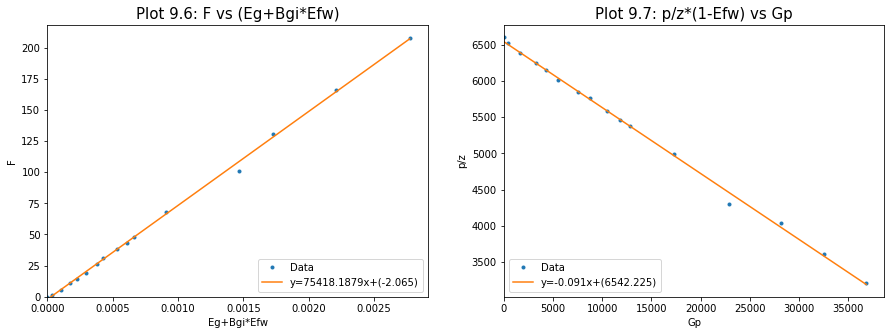

In [117]:
from scipy.optimize import curve_fit

popt1, pcov1 = curve_fit(linear, Eg_Bgi_Efw, F)
popt2, pcov2 = curve_fit(linear, data['Gp'].values, p_z_Efw)

# regression line
y1 = popt1[0] * Eg_Bgi_Efw + popt1[1]
y2 = popt2[0] * data['Gp'].values + popt2[1]

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(Eg_Bgi_Efw, F, '.', label='Data')
plt.plot(Eg_Bgi_Efw, y1, label='y={}x+({})'.format(np.round(popt1[0], 4), 
                                                   np.round(popt1[1], 4)))
plt.title('Plot 9.6: F vs (Eg+Bgi*Efw)', size=15)
plt.xlim(xmin=0); plt.ylim(ymin=0)
plt.xlabel('Eg+Bgi*Efw'); plt.ylabel('F')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(data['Gp'].values, p_z_Efw, '.', label='Data')
plt.plot(data['Gp'].values, y2, label='y={}x+({})'.format(np.round(popt2[0], 4), 
                                                          np.round(popt2[1], 4)))
plt.title('Plot 9.7: p/z*(1-Efw) vs Gp', size=15)
plt.xlim(xmin=0)
plt.xlabel('Gp'); plt.ylabel('p/z')
plt.legend(loc='lower left')

plt.show()

OGIP from Plot 9.6 is obtained from the slope $a$, OGIP from Plot 9.7 is obtained from the intercept at x-axis: $OGIP=\frac{b}{a}$

In [121]:
ogip1 = popt1[0]
ogip2 = np.abs(popt2[1] / popt2[0])
print('OGIP from Plot 9.6:', ogip1 * 1E-03, 'Bscf')
print('OGIP from Plot 9.7:', ogip2 * 1E-03, 'Bscf')

OGIP from Plot 9.6: 75.41818793272009 Bscf
OGIP from Plot 9.7: 71.87063932161676 Bscf


# ***

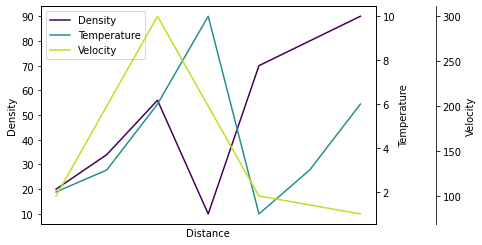

In [21]:
"Plot more than one graphs in one plot matplotlib"

import matplotlib.pyplot as plt 

x = [1, 2, 3, 4, 5, 6, 7]
y1 = [20, 34, 56, 10, 70, 80, 90]
y2 = [2, 3, 6, 10, 1, 3, 6]
y3 = [100, 200, 300, 200, 100, 90, 80]

fig = plt.figure()
host = fig.add_subplot(111)

par1 = host.twinx()
par2 = host.twinx()

# host.set_xlim(0, 2)
# host.set_ylim(0, 2)
# par1.set_ylim(0, 4)
# par2.set_ylim(1, 65)

host.set_xlabel("Distance")
host.set_ylabel("Density")
par1.set_ylabel("Temperature")
par2.set_ylabel("Velocity")

color1 = plt.cm.viridis(0)
color2 = plt.cm.viridis(0.5)
color3 = plt.cm.viridis(.9)

# p1, = host.plot([0, 1, 2], [0, 1, 2], color=color1,label="Density")
# p2, = par1.plot([0, 1, 2], [0, 3, 2], color=color2, label="Temperature")
# p3, = par2.plot([0, 1, 2], [50, 30, 15], color=color3, label="Velocity")

p1, = host.plot(x, y1, color=color1,label="Density")
p2, = par1.plot(x, y2, color=color2, label="Temperature")
p3, = par2.plot(x, y3, color=color3, label="Velocity")

lns = [p1, p2, p3]
host.legend(handles=lns, loc='best')

# right, left, top, bottom
par2.spines['right'].set_position(('outward', 60))      
# no x-ticks                 
par2.xaxis.set_ticks([])
# Sometimes handy, same for xaxis
par2.yaxis.set_ticks_position('right')